## Import Libraries

In [68]:
# Install requirements
!pip3 install transformers
!pip3 install torchvision
!pip3 install tensorflow
!pip3 install keras

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [124]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
np.random.seed(2021) # for reproducibility , to get the same results when evry your run


import random
import math
import string
import re
from datetime import datetime

from sklearn.utils import shuffle

import sys
import os
import glob
import pickle

# ML 
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# DL
from transformers import TFRobertaModel, RobertaConfig, RobertaTokenizerFast
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential




import torch
import torchvision
from transformers import AutoTokenizer, AutoConfig

import tensorflow as tf

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter

%config InlineBackend.figure_format = 'retina'
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [70]:
stopwords = set(stopwords.words('english'))
stemmer    = nltk.SnowballStemmer("english")
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'
         }


In [71]:
emo = ':)'
if emo in emojis.keys():
    print(emojis[emo])

smile


In [72]:
def clean_text(text):
    '''
        Make text lowercase, remove text in square brackets,remove links,remove punctuation
        and remove words containing numbers.
    '''
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"

    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)                # remove urls
    # text = re.compile(r'<[^>]+>')                                 # remove tages
    text = re.sub(r'\s+', ' ', text)                                # Removing multiple spaces
    text = re.sub(r'@[^\s]+', ' ', text)                            # Removing @user
    text = re.sub(sequencePattern, seqReplacePattern, text)         # Replace 3 or more consecutive letters by 2 letter.
    text = re.sub('<.*?>+', '', text)                               # remove tages
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # remove punctuation
    text = re.sub('\n', '', text)                                   # remove new line
    text = re.sub('\w*\d\w*', '', text)
    return text

In [73]:

def preprocess_data(text):
    # text = remove_quotations(text)                                            # extract text for quotations
    
    # Clean puntuation, urls, and so on
    text = clean_text(text)            
    
    # Remove stopwords
    text = ' '.join(word for word in text.split() if word not in stop_words)    
    
    # Replace all emojis.
    text = ' '.join(emojis[word] + 'EMOJI' for word in text.split() if word in emojis.keys()) 
    
    # Stem all the words in the sentence
    text = ' '.join(stemmer.stem(word) for word in text.split())                
    return text

# Importing data

In [74]:
PATH = '../input/sentiment140/training.1600000.processed.noemoticon.csv'
col_names = ['label','id','date','query','user','tweet']
encoding = 'latin'
shuffled_data = 2021
random_state = 2021

In [75]:
tweets = pd.read_csv(PATH ,encoding = encoding, names = col_names)
tweets.head()

,label,id,date,query,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [76]:
tweets.drop(['id', 'date','query','user'], axis=1, inplace=True)
tweets.head()

,label,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


### Shuffel the data!

In [77]:
text = tweets['tweet'].values
sentiment = tweets['label'].values
text[:5], sentiment[:5]

(array(["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D",
        "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!",
        '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds',
        'my whole body feels itchy and like its on fire ',
        "@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. "],
       dtype=object),
 array([0, 0, 0, 0, 0]))

In [78]:
shuffled_data = list(zip(text, sentiment))
random.shuffle(shuffled_data)

text, sentiment = zip(*shuffled_data)

tweets = pd.DataFrame({'text': text,
                        'label': sentiment})
tweets.head()

,text,label
0,@sundaybusiness None of the links you've provi...,0
1,@FizzleW Think happy thought now fizzlew hmmmm...,4
2,@dwell - Why are pre-fabricated homes so expen...,0
3,"won 2,500 neopoints!! man!! great. lol",4
4,@barbararae @charliemc1 Thanks for the complim...,4


### Makes a label for each sentiment

In [79]:
sentiment_dict = {0: 'negative',
                  2: 'neutral',
                  4: 'positive'
                  
                 }
tweets['sentiment'] = tweets['label'].map(sentiment_dict)
tweets.head(10)

,text,label,sentiment
0,@sundaybusiness None of the links you've provi...,0,negative
1,@FizzleW Think happy thought now fizzlew hmmmm...,4,positive
2,@dwell - Why are pre-fabricated homes so expen...,0,negative
3,"won 2,500 neopoints!! man!! great. lol",4,positive
4,@barbararae @charliemc1 Thanks for the complim...,4,positive
5,"i hate weekends, i miss you too much",0,negative
6,@MissxMarisa probably bella then. at least you...,4,positive
7,first time on twitter 31 may 2009,4,positive
8,@cloverink i want mencoder,4,positive
9,#uns1 also really sorry to have missed #becta ...,0,negative


In [80]:
# check for null values
print(tweets.isnull().sum())

text         0
label        0
sentiment    0
dtype: int64


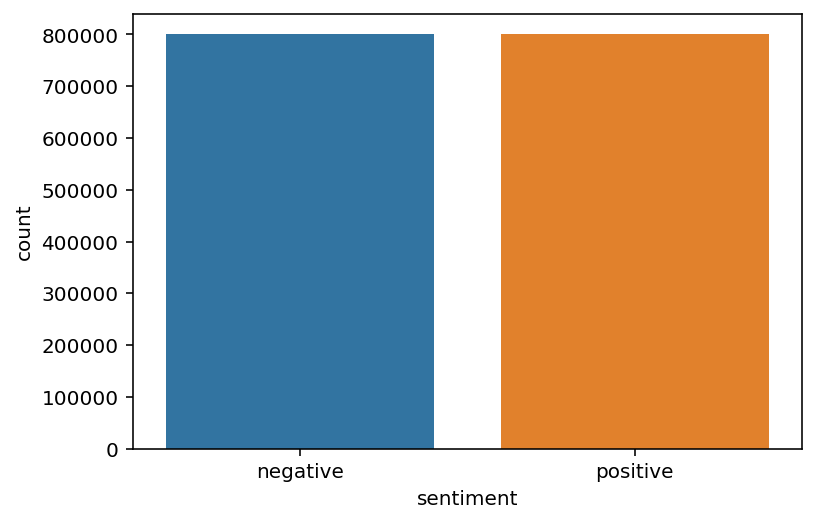

In [81]:
# tweets['sentiment'].value_counts()
sns.countplot(data= tweets, x= 'sentiment');

**Currently [0 = negative, 4 = positive] we will change it into [0 = negative, 1 = positive]**

In [82]:
tweets['label'] = tweets['label'].replace(4,1)
tweets.head(10)

,text,label,sentiment
0,@sundaybusiness None of the links you've provi...,0,negative
1,@FizzleW Think happy thought now fizzlew hmmmm...,1,positive
2,@dwell - Why are pre-fabricated homes so expen...,0,negative
3,"won 2,500 neopoints!! man!! great. lol",1,positive
4,@barbararae @charliemc1 Thanks for the complim...,1,positive
5,"i hate weekends, i miss you too much",0,negative
6,@MissxMarisa probably bella then. at least you...,1,positive
7,first time on twitter 31 may 2009,1,positive
8,@cloverink i want mencoder,1,positive
9,#uns1 also really sorry to have missed #becta ...,0,negative


## Text preprocessing.

**Showing some row text of preprocessing**

In [83]:
test = tweets['text'][:10].apply(clean_text)
test

0      none of the links youve provided in recent t...
1                 think happy thought now fizzlew hmm 
2       why are prefabricated homes so expensive it...
3                         won  neopoints man great lol
4            thanks for the compliments about my blog 
5                 i hate weekends i miss you too much 
6      probably bella then at least youll have a ri...
7                         first time on twitter  may  
8                                     i want mencoder 
9     also really sorry to have missed becta sessio...
Name: text, dtype: object

In [84]:
tweets['text'][:10]

0    @sundaybusiness None of the links you've provi...
1    @FizzleW Think happy thought now fizzlew hmmmm...
2    @dwell - Why are pre-fabricated homes so expen...
3              won 2,500 neopoints!! man!! great.  lol
4    @barbararae @charliemc1 Thanks for the complim...
5                i hate weekends, i miss you too much 
6    @MissxMarisa probably bella then. at least you...
7                  first time on twitter  31 may 2009 
8                          @cloverink i want mencoder 
9    #uns1 also really sorry to have missed #becta ...
Name: text, dtype: object

In [85]:
%%time
# apply comment_text to label column
tweets['clean_text'] = tweets['text'].apply(clean_text)

# Display first 5 samples
tweets.head(5)

CPU times: user 1min 8s, sys: 205 ms, total: 1min 8s
Wall time: 1min 9s


,text,label,sentiment,clean_text
0,@sundaybusiness None of the links you've provi...,0,negative,none of the links youve provided in recent t...
1,@FizzleW Think happy thought now fizzlew hmmmm...,1,positive,think happy thought now fizzlew hmm
2,@dwell - Why are pre-fabricated homes so expen...,0,negative,why are prefabricated homes so expensive it...
3,"won 2,500 neopoints!! man!! great. lol",1,positive,won neopoints man great lol
4,@barbararae @charliemc1 Thanks for the complim...,1,positive,thanks for the compliments about my blog


### Analyzing Text Statistics

In [86]:
tweets['text_n_chars'] = tweets.clean_text.apply(len) # count all chars in each sentence
tweets['text_n_words'] = tweets.clean_text.apply(lambda sent: len(sent.split())) # count number of words in each sentence
tweets.head()

,text,label,sentiment,clean_text,text_n_chars,text_n_words
0,@sundaybusiness None of the links you've provi...,0,negative,none of the links youve provided in recent t...,64,11
1,@FizzleW Think happy thought now fizzlew hmmmm...,1,positive,think happy thought now fizzlew hmm,38,6
2,@dwell - Why are pre-fabricated homes so expen...,0,negative,why are prefabricated homes so expensive it...,125,22
3,"won 2,500 neopoints!! man!! great. lol",1,positive,won neopoints man great lol,28,5
4,@barbararae @charliemc1 Thanks for the complim...,1,positive,thanks for the compliments about my blog,43,7


In [87]:
max_length = max(tweets['text_n_words'])
max_length

40

### Splitting the data

Training Data: contains 95% data.


Test Data: contains 5% data.


In [88]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(tweets.clean_text.values, tweets.label,
                                                    test_size = 0.05, random_state = random_state)

In [89]:
len(X_train), len(X_test), len(y_train), len(y_test)

(1520000, 80000, 1520000, 80000)

# Modeling

## Machine Learning Models.

### TF-IDF Vectoriser

In [90]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
X_train = vectoriser.fit_transform(X_train)
X_test  = vectoriser.transform(X_test)

#### We will use:
* **Bernoulli Naive Bayes (BernoulliNB)**
* **Linear Support Vector Classification (LinearSVC)**
* **Logistic Regression (LR)**


#### Wthat the difference between the the Gaussian, Bernoulli, Multinomial and the regular Naive Bayes algorithms? [quora](https://www.quora.com/What-is-the-difference-between-the-the-Gaussian-Bernoulli-Multinomial-and-the-regular-Naive-Bayes-algorithms)


**Bernoulli Naive Bayes** : It assumes that all our features are `binary` such that they take only two values. Means 0s can represent “word does not occur in the document” and 1s as "word occurs in the document" .

**Multinomial Naive Bayes** : Its is used when we have `discrete data` (e.g. movie ratings ranging 1 and 5 as each rating will have certain frequency to represent). In text learning we have the count of each word to predict the class or label.

**Gaussian Naive Bayes** : Because of the assumption of the normal distribution, Gaussian Naive Bayes is used in cases when all our `features are continuous`. For example in Iris dataset features are sepal width, petal width, sepal length, petal length. So its features can have different values in data set as width and length can vary. We can’t represent features in terms of their occurrences. This means data is continuous. Hence we use Gaussian Naive Bayes here.



**Evaluate Model Function:**

In [91]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
    return acc

**1- BernoulliNB**

              precision    recall  f1-score   support

           0       0.81      0.78      0.79     40047
           1       0.79      0.82      0.80     39953

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000

CPU times: user 984 ms, sys: 80 ms, total: 1.06 s
Wall time: 1.04 s


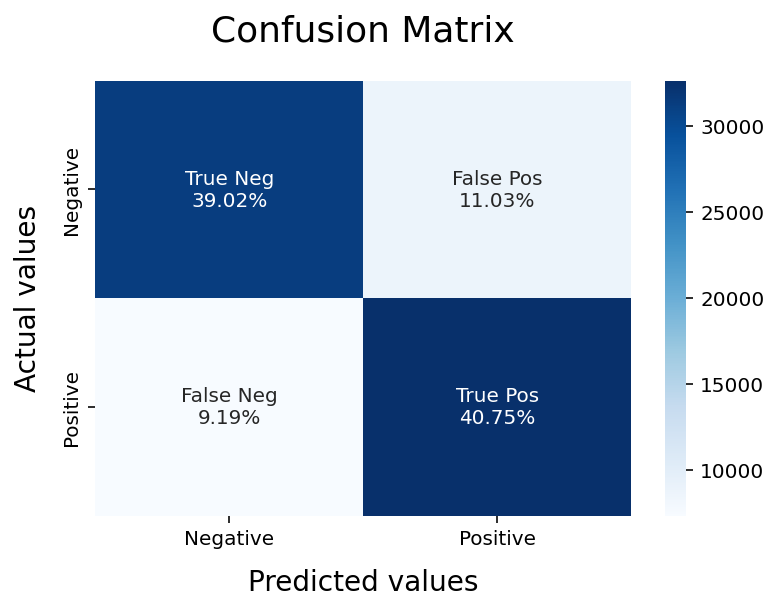

In [92]:
%%time
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
BernoulliNB_acc = model_Evaluate(BNBmodel)

**2- LinearSVC**

              precision    recall  f1-score   support

           0       0.82      0.81      0.81     40047
           1       0.81      0.82      0.82     39953

    accuracy                           0.81     80000
   macro avg       0.81      0.81      0.81     80000
weighted avg       0.81      0.81      0.81     80000

CPU times: user 30.4 s, sys: 286 ms, total: 30.6 s
Wall time: 30.6 s


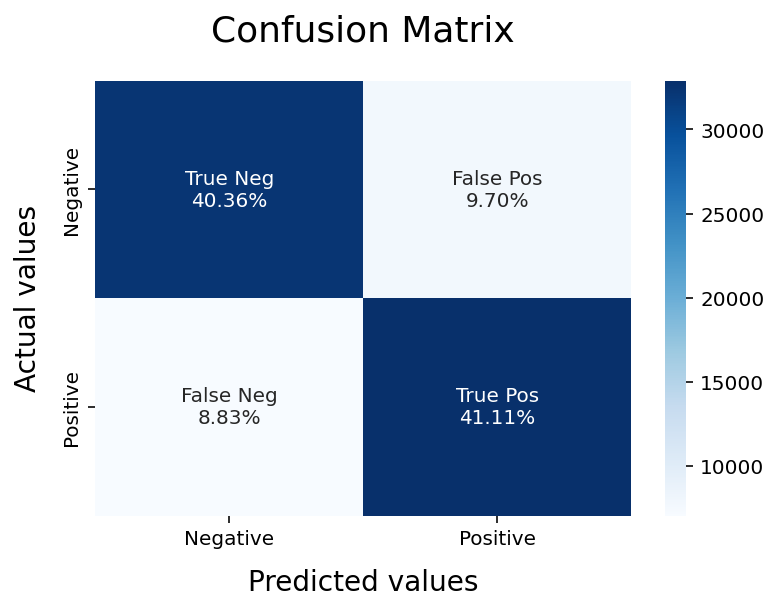

In [93]:
%%time
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
SVC_acc = model_Evaluate(SVCmodel)

**3- Logistic Regression Model**

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
              precision    r

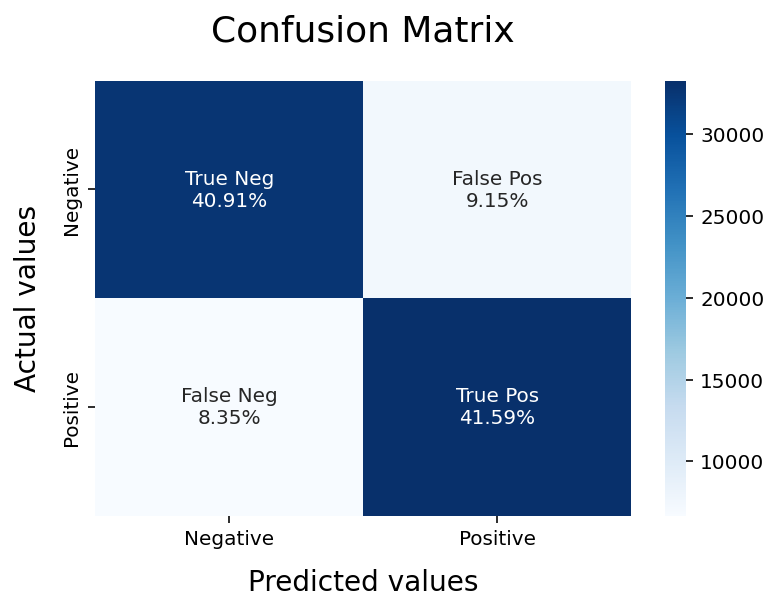

In [94]:
%%time

lr = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
# lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_acc = model_Evaluate(lr)


**As we sow the LinearSVC is the faster one and get good accuracy 81%**

### Save the model
We're using PICKLE to save Vectoriser and LinearSVC Model for later use.


In [95]:
file = open('vectoriser-ngram-(1,2).pickle','wb')
pickle.dump(vectoriser, file)
file.close()

file = open('Sentiment-LSVC.pickle','wb')
pickle.dump(SVCmodel, file)
file.close()

### Use the model

In [96]:
def load_models():
    '''
    Replace '..path/' by the path of the saved models.
    '''
    
    # Load the vectoriser.
    
    file = open('./vectoriser-ngram-(1,2).pickle', 'rb')
    vectoriser = pickle.load(file)
    file.close()

    # Load the LSVC Model.
    file = open('./Sentiment-LSVC.pickle', 'rb')
    LSVC_model = pickle.load(file)
    file.close()
    
    return vectoriser, LSVC_model

In [97]:
# Loading the models.
vectoriser, LinearSVC = load_models()

In [98]:
def one_predict(vectoriser, model, text):
    # Predict the sentiment
    textdata = vectoriser.transform([clean_text(text)])
#     textdata = vectoriser.fit_transform(clean_text(text))
    sentiment = model.predict(textdata)[0]
    return "Negative" if sentiment == 0 else "Positive"

def multiple_predict(vectoriser, model, texts):
    # Make a list of text with sentiment.
    data = []
    for text in texts:
        # Predict the sentiment
        textdata = vectoriser.transform([clean_text(text)])
        sentiment = model.predict(textdata)[0]
        data.append((text,sentiment))
        
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    df = df.replace([0,1], ["Negative","Positive"])
    return df

### Predicting

In [102]:
tweet = "i love twitter"
sentiment = one_predict(vectoriser, LinearSVC, text)
print(sentiment)

Positive


In [100]:
# Text to classify should be in a list.
text = ["I hate twitter",
        "i love twitter",
        "This is my good day!"]
sentiment = multiple_predict(vectoriser, LinearSVC, text)
sentiment

,text,sentiment
0,I hate twitter,Negative
1,i love twitter,Positive
2,This is my good day!,Positive
